# Fashion MNIST exploration and classificator development
Elena Markoska

For this exercise we're going to use the Fashion MNIST dataset. Essentially it is a collection of images of a variety of clothing items, accessories, and shoes. They are classified in 10 classes.

In this notebook, we're going to load the dataset, explore the data a little bit, preprocess the data, develop a deep neural network based on convolutional layers for a classifier, evaluate the classifier, and write some code to make predictions on single values.

The code in this notebook is afterwards transferred to a python module that can be afterwards imported for future usage.

First, we're going to import all the necessary libraries we're going to need.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

#import sys
#!{sys.executable} -m pip install tensorflow

The data for the Fashion MNIST dataset has been obtained from its [Github repository](https://www.kaggle.com/orhansertkaya/convolutional-neural-network-cnn-fashion-mnist) where it can be found in .gz files. We use the following function provided in the same repository.


In [0]:
def load_mnist(path, kind):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Next, we're going to import the data into training set and test set.

In [0]:
X_train, y_train = load_mnist('/content/', kind='train')
X_test, y_test = load_mnist('/content/', kind='t10k')

Let's have a look at one image just to get a feeling for what they are like.

(10000, 28, 28, 1)


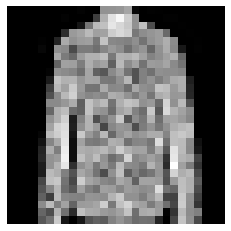

In [20]:
print(X_test.shape)
plt.imshow(X_test[101].reshape(28,28),cmap="gray")
plt.axis("off")
plt.show()

To verify wherher we have a balanced classification problem or imbalanced, we'll have a look at the distribution between the classes in the training set. It seems the dataset is perfectly balanced. This makes it easier for us to train a classifier.

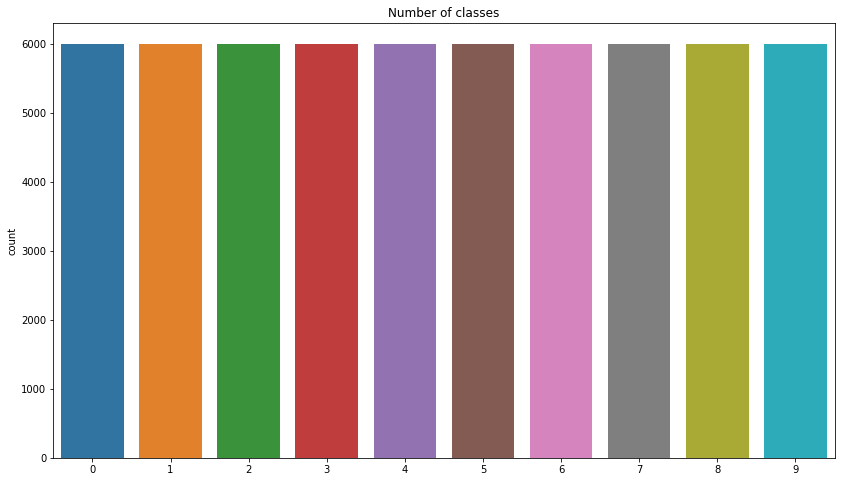

In [5]:
plt.figure(figsize=(14,8))
sns.countplot(y_train)
plt.title("Number of classes")
plt.show()

As per the suggestion of a [kaggle kernel](https://www.kaggle.com/orhansertkaya/convolutional-neural-network-cnn-fashion-mnist), we're going to do some normalisation on the data. That is, we'll do a grayscale normalisation to reduce the effect of differences in illumination. Convolutional neural networks are also faster on normalised data.

Next, we're going to reshape the datasets. The images will be transformed into 28x28 and all the data will be reshaped into 28x28x1 matrices. The 1 in the 3D matrix corresponds to the one channel as the images are gray scaled.

Finally, we're going to encode the labels into one-hot vectors instead of integers.

In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)


In [0]:
# convert to one-hot-encoding(one hot vectors)
y_train = to_categorical(y_train, num_classes = 10)
# convert to one-hot-encoding(one hot vectors)
y_test = to_categorical(y_test, num_classes = 10)

In [8]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


After our preprocessing is done, we're going to split the dataset into a training and a validation set. We're going to use the training set for this, and leave the initial test set untouched.

The arthicture of the model is as follows. Two convolutional layers followed by a fully connected layer. We're using a Dropout layer, too, to reduce the chance of overfitting. Finally we're using the softmax activation function which will give a probability of an input image being any of the 10 classes.

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)

In [0]:
model = Sequential()

#1. LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#3. LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

#OUTPUT LAYER
model.add(Dense(10, activation='softmax'))


We're going to use the Adam optimiser as it's generally a good choice, and categorical crossentropy as we have a multi-classification problem.
We're going to train on 50 epochs with a batch size of 1000. The epochs were chosen arbitrarily, while the batch size was deliberately chosen to be larger to reduce training time. Lastly, we're going to do some data augmentation as per the example of the aforementioned kaggle kernel.

Afterwards, we're going to fit/train the model.

In [0]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50
batch_size = 1000

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [13]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              shuffle=True, epochs=epochs, validation_data = (x_val, y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
 - 107s - loss: 0.6912 - accuracy: 0.7495 - val_loss: 2.4071 - val_accuracy: 0.1188
Epoch 2/50
 - 104s - loss: 0.4505 - accuracy: 0.8359 - val_loss: 2.5665 - val_accuracy: 0.1147
Epoch 3/50
 - 104s - loss: 0.3939 - accuracy: 0.8537 - val_loss: 2.5302 - val_accuracy: 0.2257
Epoch 4/50
 - 104s - loss: 0.3595 - accuracy: 0.8672 - val_loss: 2.1537 - val_accuracy: 0.4373
Epoch 5/50
 - 104s - loss: 0.3453 - accuracy: 0.8709 - val_loss: 1.9885 - val_accuracy: 0.4873
Epoch 6/50
 - 104s - loss: 0.3264 - accuracy: 0.8789 - val_loss: 1.4059 - val_accuracy: 0.5640
Epoch 7/50
 - 103s - loss: 0.3151 - accuracy: 0.8844 - val_loss: 1.0895 - val_accuracy: 0.6357
Epoch 8/50
 - 104s - loss: 0.3021 - accuracy: 0.8882 - val_loss: 0.6427 - val_accuracy: 0.7793
Epoch 9/50
 - 104s - loss: 0.2978 - accuracy: 0.8893 - val_loss: 0.4084 - val_accuracy: 0.8635
Epoch 10/50
 - 104s - loss: 0.2900 - accuracy: 0.8926 - val_loss: 0.2893 - val_accuracy: 0.9033
Epoch 11/50
 - 104s - loss: 0.2780 - accuracy: 0.

To see the performance of our model and check for possible hints of overfitting, we're going to use the function below. The function plots relevant aspects of the history object returned from model.fit().

In [0]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

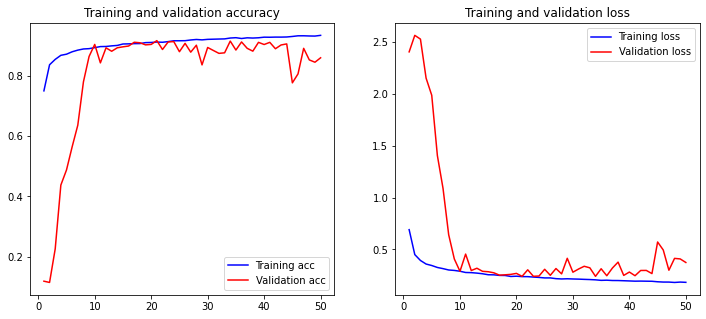

In [17]:
plot_history(history)

There seem to be no signs of overfitting, and our accuracy seems to be fairly high. We're going to leave the model as it is for now. As the training of the model took a considerable amount of time, this isn't a step we'd like to repeat again. Thus, we're going to save the model and then afterwards load it when we want to make predictions.

In [21]:
model.save('/content/model_saved.h5') #Save the model

from keras.models import load_model
model = load_model('/content/model_saved.h5')

trueY = y_test[101]
img = X_test[101]
test_img = img.reshape(1,28,28,1)
preds = model.predict_classes(test_img)
print("Preds: ",preds)

Preds:  [6]
